In [1]:
import pandas as pd 
import numpy as np
from tqdm.auto import tqdm

from utils import create_time_series_splits

In [ ]:
df = pd.read_csv('./preprocessed_data.csv', sep=',', parse_dates=['Datetime'], index_col=0)
df.index = pd.to_datetime(df['Datetime'], utc=True)
df.drop(columns=['Datetime'], inplace=True)
df.dropna(inplace=True)

excluded_columns = ['Total Load', 'Most recent forecast', 'Most recent P10',
       'Most recent P90', 'Day-ahead 6PM forecast', 'Day-ahead 6PM P10',
       'Day-ahead 6PM P90', 'Week-ahead forecast', 'Year', 'Month', 'Day',
       'Hour', 'Minute', 'Season', 'Lockdown']

In [115]:
splits = create_time_series_splits(
    data=df,
    train_size_days=7*4*12, # 6 month for training (all times)
    test_size_days=7*4, # 1 month for testing (only at 6pm)
    num_splits=1,
    window_size_steps=4*30, # 6 hours window
    exclude_columns=excluded_columns,
    target_column='Total Load Interpolated',
    prediction_horizon_steps=4*30, # 30 hours step ahead forecast
    shifting_steps=1,
    elia_column_to_return='Day-ahead 6PM forecast',
    alignment_times=['18:00']
)

100%|██████████| 2688/2688 [00:00<00:00, 46271.34it/s]


In [116]:
split_idx = 0
X_train = splits[split_idx]['X_train'].to_numpy()
Y_train = splits[split_idx]['Y_train'].to_numpy()
X_test = splits[split_idx]['X_test'].to_numpy()
Y_test = splits[split_idx]['Y_test'].to_numpy()
ELIA_train = splits[split_idx]['ELIA_train'].to_numpy()
ELIA_test = splits[split_idx]['ELIA_test'].to_numpy()

In [117]:
X_train.shape, Y_train.shape

((32256, 120), (32256, 120))

In [118]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
from torch.utils.data import DataLoader, TensorDataset

device = 'mps'

class SimpleMLP(nn.Module):
    def __init__(self, input_size, output_size, embedded_vector_size, non_linear_vector_size):
        super(SimpleMLP, self).__init__()
        self.l_nl = nn.Linear(input_size, non_linear_vector_size).to(device)
        self.l_l = nn.Linear(input_size, embedded_vector_size).to(device)
        self.l = [nn.Linear(non_linear_vector_size+input_size+embedded_vector_size, embedded_vector_size+1).to(device)]
        for i in range(1, output_size+1):
            self.l.append(nn.Linear(non_linear_vector_size+input_size+2*embedded_vector_size+1, embedded_vector_size+1).to(device))
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        outputs = []
        x_linear = self.l_l(x)
        x_non_linear = self.tanh(self.l_nl(x))

        xs = [self.l[0](torch.concatenate([x, x_linear, x_non_linear], axis=-1))]
        for i in range(1, output_size+1):
            xs.append(self.l[i](torch.concatenate([x, x_linear, x_non_linear, xs[-1]], axis=-1)))
            outputs.append(xs[-1][:, -1:])
        
        out = torch.concatenate(outputs, axis=-1)
        return out

batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(Y_train[:, -4:], dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(Y_test[:, -4:], dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X_train.shape[1]
output_size = 4#Y_train.shape[1]
#torch.manual_seed(42)
model = SimpleMLP(input_size, output_size, input_size//4, input_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, criterion, optimizer, epochs=100):
    model.train()
    for epoch in tqdm(range(epochs)):
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            loss.backward()
            optimizer.step()


def predict(model, test_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X_batch, _ in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch).to('cpu')
            predictions.append(outputs)
    return torch.cat(predictions, dim=0)

train(model, train_loader, criterion, optimizer)
Y_pred = predict(model, test_loader).numpy()

  0%|          | 0/100 [00:00<?, ?it/s]

In [119]:
mape_l_nl_net = (abs(Y_pred - Y_test[:, -4:]) / Y_test[:, -4:])

In [120]:
mape_elia = (abs(ELIA_test[:, -4:] - Y_test[:, -4:]) / Y_test[:, -4:])

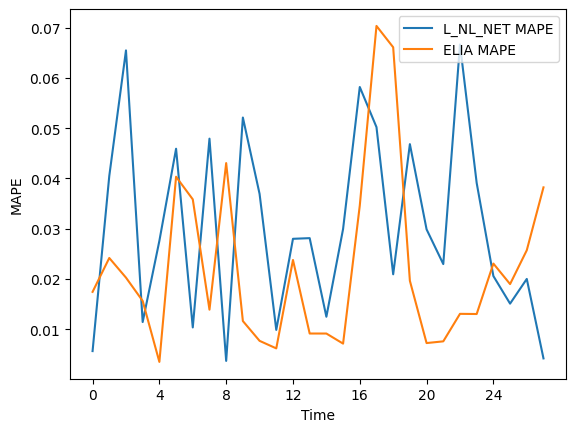

In [121]:
import matplotlib.pyplot as plt
plt.plot(mape_l_nl_net.mean(axis=1), label='L_NL_NET MAPE')
plt.plot(mape_elia.mean(axis=1), label='ELIA MAPE')
plt.xlabel('Time')
plt.xticks(range(0, len(mape_l_nl_net.mean(axis=1)), 4))
plt.ylabel('MAPE')
plt.legend()